
# Predicting Game Success: A Regression Analysis on the Steam Games Dataset #
By Gabriel Bertasius & Jaden Ford


Steam is a mainstream video game platform on the PC. There are over 80,000 games on the platform and it's ease of use makes it not only the go-to for gamers, but also for game developers when it comes to publishing and distributing games. The aim of our project is to analyse the data from this platform with the purpose of predicting what makes for a successful video game. We use the Fronkon Games Steam Games Dataset for this purpose. We select key factors which we think will predict success and train a multi-output Random Forest regression model. We developed a weighted score based on the $R{^2}$ score and sentiments based on given reviews.

Contributions
- Downloading and Loaders: Gabriel
- Pre-processing and Data Selection: Jordan
- Word2Vec Embedding and Clustering: Gabriel
- Sentiment Analysis: Gabriel
- Train/test data extraction and Regression: Jordan
- Success Rating: Jordan 

In [18]:
from datetime import datetime
import numpy as np
import pandas as pd
import os
import pickle
import gzip
from datetime import datetime

import hdbscan
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from dataclasses import dataclass, field
from sklearn.metrics import silhouette_score, adjusted_rand_score, make_scorer, r2_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

import gensim
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.decomposition import PCA

import torch
from scipy.special import softmax
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# show all columns
pd.set_option('display.max_columns', None)

## Downloading and loading data

In [19]:
# load the data into a dataframe for easy handling
DATASET_DIR = './data/'
DATASET_FILENAME = 'steamgames.parquet'
DATASET_PATH = DATASET_DIR+DATASET_FILENAME
DATASET_COMPRESSION = 'zstd'  # Very fast and compresses as well as gzip
MODELS_DIR = './models/'
MODELS_FILENAME = 'model-'
download_data = 1


def check_file_exists(path: str) -> bool:
    return os.path.exists(path)


def check_data_dir_exists() -> bool:
    return os.path.exists(DATASET_DIR)

def check_models_dir_exists() -> bool:
    return os.path.exists(MODELS_DIR)

def create_data_dir():
    directory_name = DATASET_DIR
    try:
        os.mkdir(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

def create_models_dir():
    directory_name = MODELS_DIR 
    try:
        os.mkdir(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

def download_steamgames_dataset() -> pd.DataFrame:
    df = pd.read_parquet(
        "hf://datasets/FronkonGames/steam-games-dataset/data/train-00000-of-00001-e2ed184370a06932.parquet")
    return df


def write_dataset_pqt(df: pd.DataFrame, filename: str = DATASET_FILENAME, overwrite: bool = False) -> bool:
    dir = DATASET_DIR
    path = dir+filename
    if (check_data_dir_exists() == False):
        create_data_dir()
    if check_file_exists(path) and overwrite == False:
        print("File exists. Pass 'overwrite' to replace.")
        return False
    else:
        df.to_parquet(path, compression='zstd')
        return True


def read_dataset_pqt(filename: str = DATASET_FILENAME):
    path = DATASET_DIR+filename
    if check_file_exists(path):
        print("Loading dataset from local storage...")
        prq = pd.read_parquet(path)
        print("✅ Local dataset loaded.")
        return prq
    else:
        print("Parquet file not found.")

def datestamp():
    """ Get the current datestamp """
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def write_model_log(path:str, config: dict, **kwargs):
    with open(path+".txt", "a") as file:
        file.write(f"[{datestamp()}]\n")
        file.write(f"{config}\n")
        if kwargs:
            for x in kwargs:
                file.write(f"{x}\n")
    
def pickle_model(filename: str, model, params_dict:dict, param_grid:dict = None,overwrite: bool=False, **extra_data):
    dir = MODELS_DIR 
    path = dir+filename
    for s in params_dict.values():
        path += f'-{s}'
    if (check_models_dir_exists() == False):
        create_models_dir()
    if check_file_exists(path) and overwrite == False:
        print("File exists. Pass 'overwrite' to replace.")
        return False
    else:
        if param_grid is not None:
            write_model_log(path, param_grid, **extra_data)
        else:
            write_model_log(path, params_dict)
        level = 7   # Good balance between speed and compression
        with gzip.open(path+".pkl.gz", "wb", compresslevel=level) as file:
            pickle.dump(model, file, protocol=5)
        return True

def unpickle_model(filename):
    path = MODELS_DIR+filename
    with gzip.open(path+".pkl.gz", "rb") as file:
        return pickle.load(file)
    
def download_and_save_dataset(force: bool = False, filename: str = DATASET_FILENAME) -> pd.DataFrame | None:
    dir = DATASET_DIR
    path = dir+filename
    if (check_file_exists(path)):
        print(f"⚠️ Dataset exists locally. Path:{path}")
        if (force == False):
            print("Use force=True to download and overwrite.")
            return None
        else:
            print("Redownloading and Overwriting...")
    else:
        print(f"Downloading and saving dataset to {path} ")
    df = download_steamgames_dataset()
    write_dataset_pqt(df, overwrite=False)
    print("✅ Done.")
    print(f"Saved to: {path}")
    return df


df = download_and_save_dataset(force=False)
if(df is None):
    df = read_dataset_pqt()

⚠️ Dataset exists locally. Path:./data/steamgames.parquet
Use force=True to download and overwrite.
Loading dataset from local storage...
✅ Local dataset loaded.


## Pre-processing data

In [20]:
# Check for any missing values
sum = df.isnull().sum()
sum[sum != 0]

Name                  6
About the game     3437
Reviews           73844
Website           44506
Support url       42544
Support email     13319
Metacritic url    79650
Score rank        83516
Notes             70845
Developers         3457
Publishers         3705
Categories         4456
Genres             3425
Tags              19986
Screenshots        1926
Movies             6300
dtype: int64

#### Drop irrelevant columns

In [21]:
# remove any columns that won't contribute to a game's success rating
cols_to_remove = ['About the game', 'Supported languages', 'Full audio languages',
                  'Header image', 'Website', 'Support url', 'Support email', 'Metacritic url',
                  'Score rank', 'Screenshots', 'Movies']
df = df.drop(columns=cols_to_remove, axis=1)
df.head()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,Reviews,Windows,Mac,Linux,Metacritic score,User score,Positive,Negative,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,None,True,False,False,0,0,6,11,30,0,None,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,None,True,True,False,0,0,53,5,12,0,None,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,None,True,False,False,0,0,0,0,0,0,None,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",None
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,None,True,True,True,0,0,3,0,0,0,None,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,None,True,True,False,0,0,50,8,17,0,This Game may contain content not appropriate ...,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."


#### Standardizing data and pre-processing

In [22]:
# function that calculates the number of years since a game's release date
def years_since_release(date_string):
  if len(date_string) == 11 or len(date_string) == 12:
        date = datetime.strptime(date_string, "%b %d, %Y")
  else: # length must be 8 or 9
      date = datetime.strptime(date_string, "%b %Y")

  current_date = datetime.now()
  years = (current_date - date).days / 365
  return years

# function to return the avg number of estimated owners
def est_owners(num_owners):
  numbers = num_owners.split('-')
  return (int(numbers[0]) + int(numbers[1])) / 2

# function to normalize a numerical column between 0-1 based on min and and max values
def min_max_normalize(column):
  column = np.array(column)
  norm_col = ( column - np.min(column) ) / ( np.max(column) - np.min(column) )
  return norm_col

In [23]:
# convert release date to years since release
df['Release date'] = df['Release date'].apply(years_since_release)

# return middle value for each given range of estimated owners
df['Estimated owners'] = df['Estimated owners'].apply(est_owners)

# convert windows, mac, and linux columns from boolean to integer
df['Windows'] = df['Windows'].astype(int)
df['Mac'] = df['Mac'].astype(int)
df['Linux'] = df['Linux'].astype(int)

In [24]:
# Filter out any games that are free, have no peak ccu, and no estimated owners
# This allows us to judge success based on games that competed in certain markets, and have had actual people play them
no_peak_ccu_cols = df[df['Peak CCU'] == 0].index
df = df.drop(no_peak_ccu_cols, axis=0)

no_est_owners_cols = df[df['Estimated owners'] == 0].index
df = df.drop(no_est_owners_cols, axis=0)

no_price_cols = df[df['Price'] == 0].index
df = df.drop(no_price_cols, axis=0)

Data for later use in sentiment analysis and model performance calculations.

In [25]:
# keep a copy of pre_normalized values
df_orig = df.copy(deep=True)

# store reviews for sentiment analysis
df_reviews = df['Reviews'].copy(deep=True)

In [26]:
# normalize any large value ranges
cols_to_normalize = ['Release date', 'Estimated owners', 'Peak CCU', 'Required age', 'Price', 'DLC count',
                     'Metacritic score', 'User score', 'Positive', 'Negative', 'Achievements',
                     'Recommendations', 'Average playtime forever', 'Average playtime two weeks',
                     'Median playtime forever', 'Median playtime two weeks']
for col in cols_to_normalize:
  df[col] = min_max_normalize(df[col])

In [27]:
print("Normalized Data")
df.head()

Normalized Data


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,Reviews,Windows,Mac,Linux,Metacritic score,User score,Positive,Negative,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags
6,1659180,TD Worlds,0.071606,0.000000,0.000002,0.0,0.039460,0.000423,None,1,0,0,0.000000,0.0,0.000022,0.000051,0.006313,0.000000,None,0.00000,0.0,0.000000,0.0,MAKSIM VOLKAU,MAKSIM VOLKAU,"Single-player,Steam Achievements,Steam Cloud","Indie,Strategy","Tower Defense,Rogue-lite,RTS,Replay Value,Perm..."
7,1968760,Legend of Rome - The Wrath of Mars,0.059585,0.000000,0.000001,0.0,0.035751,0.000000,None,1,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,None,0.00000,0.0,0.000000,0.0,magnussoft,magnussoft,"Single-player,Steam Cloud",Casual,None
8,1178150,MazM: Jekyll and Hyde,0.138653,0.000000,0.000000,0.0,0.054295,0.000000,None,1,0,0,0.000000,0.0,0.000079,0.000043,0.002546,0.000000,None,0.00000,0.0,0.000000,0.0,Growing Seeds,"CFK Co., Ltd.","Single-player,Steam Achievements,Full controll...","Adventure,RPG,Simulation,Strategy","Adventure,Simulation,RPG,Strategy,Singleplayer..."
10,1026420,WARSAW,0.157617,0.000333,0.000005,0.0,0.087672,0.000000,“New WW2 Strategy Game Offers A Harrowing Look...,1,0,0,0.639175,0.0,0.000610,0.001530,0.003462,0.000475,None,0.00046,0.0,0.000446,0.0,Pixelated Milk,"Pixelated Milk,gaming company","Single-player,Steam Achievements,Steam Trading...","Indie,RPG","Tactical RPG,Turn-Based Strategy,Wargame,Histo..."
14,1454010,Diary of Lucie,0.114093,0.000000,0.000002,0.0,0.046877,0.000000,None,1,0,0,0.000000,0.0,0.000104,0.000036,0.000000,0.000000,None,0.00000,0.0,0.000000,0.0,Parange Project,Parange Project,"Single-player,Partial Controller Support,Steam...","Action,Adventure,Indie,RPG,Strategy,Early Access","Action Roguelike,Action,Rogue-lite,RPGMaker,My..."


### Counting unique words in Categories, Genres, Tags

'Dumb counting' as in the tags 'turn-based' and 'turn-based combat' or 'turn-based strategy' are different words. These should be ok for word2vec as they likely appear close to each other.

In [28]:
def count_unique_words(df, label:str):
    lists:pd.Series= df[label].str.casefold().str.split(',')
    words = set()
    [words.update(x) for x in lists if x is not None]
    
    print(f"Number of unique {label}: {len(words)}")
    return len(words),words

count_unique_words(df_orig, 'Categories') # 39
count_unique_words(df_orig, 'Genres') # 27
tags_count_unique, tags_list_unique = count_unique_words(df_orig, 'Tags') # 444
pass;

Number of unique Categories: 39
Number of unique Genres: 27
Number of unique Tags: 444


#### One hot encoding Catergories and Genres

In [29]:
encoded_categories = df['Categories'].str.get_dummies(sep=',')
encoded_genres = df['Genres'].str.get_dummies(sep=',')

df = pd.concat([df, encoded_categories, encoded_genres], axis=1)
df = df.drop(columns=['Categories', 'Genres'], axis=1)
print(df.shape)

(20194, 92)


### Word2Vec embedding for Tags feature

#### Training word2vec model

In [30]:
class TagProcessor:
    def __init__(self, df: pd.DataFrame, label: str):
        self.df: pd.DataFrame = df
        self.label: str = label
        self.tags_series: pd.Series = self.df[self.label].str.casefold().str.split(',')
        self.tags_series: pd.Series = self.tags_series.apply(lambda x: ['none'] if x is None else x)
        self.tags_dict: dict = {}
        self.total_occurrences: int = 0
        self.sentences: list = [sentence for sentence in self.tags_series]

        self.initialize_tags()
        self.count_tags() 

    def initialize_tags(self):
        tags_list_unique = set(
            tag for sublist in self.tags_series if sublist is not None for tag in sublist)
        self.tags_dict = {x: 0 for x in tags_list_unique}

    def count_tags(self):
        word_list = [
            y for x in self.tags_series if x is not None for y in x]
        self.total_occurrences = len(word_list)
        for x in word_list:
            self.tags_dict[x] += 1

    def get_sorted_tags(self):
        return sorted(self.tags_dict.items(), key=lambda x: x[1], reverse=True)

    def calculate_frequencies(self):
        return {x: y / self.total_occurrences * 100 for x, y in self.tags_dict.items()}

    def get_sorted_frequencies(self):
        word_freq = self.calculate_frequencies()
        return sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    def stringify_tags(self):
        str_sentences = [[', '.join(x)] for x in self.sentences]
        str_sentences = [f'{x[0]}' for x in str_sentences]
        return str_sentences

tag_processor: TagProcessor = TagProcessor(df_orig, 'Tags')

In [31]:
import warnings
# suppress DerecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module='gensim')

# Code adapted from:
# https://www.kaggle.com/competitions/word2vec-nlp-tutorial/overview
class s_word2vec:
# model_name = "100features_1minwords_10context"
    def __init__(self, n_features=100, min_wc=1, context=10, n_threads=2, downsample=1e-3):
        self.model:gensim.models.Word2Vec = None
        self.num_features = n_features# Word vector dimensionality
        self.min_word_count = min_wc  # Minimum word count
        self.context = context         # Context window size
        self.model_name = f'{self.num_features}-feat_{self.min_word_count}-minwords_{self.context}-context'

        self.num_workers = n_threads # Number of threads to run in parallel
        self.downsampling = downsample  # Downsample setting for frequent words
        self.labels = None

    def _init_sims(self):
        """ Normalize model """
        print("get_mean_vector is deprecated. Use get_vector(key, norm=True) instead")
        self.model.init_sims(replace=True)

    def load_model(self, X=tag_processor.sentences):
        try:
            check_file_exists(self.model_name)
            print("Loading saved model: ", self.model_name)
            self.model = gensim.models.Word2Vec.load(self.model_name)
            self._init_sims(self.model)
        except:
            print("Unable to find model")

    def set_labels(self,labels):
        self.labels=labels

    def train_model(self, X=tag_processor.sentences) -> gensim.models.Word2Vec:
        print("Training model...")
        
        self.model = gensim.models.Word2Vec(
            X,
            workers=self.num_workers,
            vector_size=self.num_features,
            min_count=self.min_word_count,
            window=self.context,
            sample=self.downsampling,
        )
        self._init_sims()
        self.model.save(self.model_name)
        return self.model;

w2v_params = {
    'n_features': [70, 100, 150],
    'min_wc' : [4, 6, 10],
    'context': [7, 10, 15] 
}

# tags_w2v_model = s_word2vec(n_features=70, min)
# w2vmodel = tags_w2v_model.train_model() # train on all tags by default

import itertools
param_combinations = list(itertools.product(
    w2v_params['n_features'],
    w2v_params['min_wc'],
    w2v_params['context']))

# Initialize an empty list to hold the models
w2v_models = []
w2v_features = []

# Create models for each combination of parameters
for n_features, min_wc, context in param_combinations:
    smodel = s_word2vec(n_features=n_features, min_wc=min_wc, context=context)
    w2vmodel= smodel.train_model();
    tags_vectors = [
        w2vmodel.wv.get_mean_vector(game, pre_normalize=False, post_normalize=False)
        for game in tag_processor.sentences
    ]
    w2vdf = pd.DataFrame(tags_vectors)
    assert w2vdf.shape[1] == smodel.num_features
    w2vdf.columns = [f'w2v_embed_{i}' for i in range(smodel.num_features)]
    w2v_models.append(w2vdf)
    w2v_features.append([n_features, min_wc, context])


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Since there are many tags and one-hot encoding them would produce very sparse embeddings and increase model complexity. Using word2vec, it's possible to reduce the embedding size. Word2vec in this context will produce vectors for each tag. The embedding for the tags is an average of the tag all the tag vectors for a given game. This results in d-dimensional feature embedding where d is the numer of dimensions specified in word2vec training.

### HDBSCAN clustering


Since it is difficult to score word2vec without an objective test set, we can attempt to use clustering to see if any one word2vec embedding is able to better capture the relationships between tags. This will allow for fine-tuning the word2vec hyperparameters by observing how well similar sets of tags are able to be clustered. 

In [32]:
# from sklearn.cluster import HDBSCAN
# X_train, X_test = train_test_split(tags_vectors, test_size=0.2, train_size=0.8, random_state=42, shuffle=True)

class HDBSCANOptimizer:
    def __init__(self, min_samples=None, min_cluster_size=None, n_iter_search=20, seed=42):
        self.min_samples = min_samples or [50, 70]
        self.min_cluster_size = min_cluster_size or [12] # best found size
        self.n_iter_search = n_iter_search
        self.seed = seed
        self.random_search = None

    def search(self, X):
        param_dist = {
            'min_samples': self.min_samples,
            'min_cluster_size': self.min_cluster_size,
            # 'cluster_selection_epsilon': self.min_epsilon,
            # 'cluster_selection_method': ['eom', 'leaf'],
            'metric': ['manhattan', 'euclidean']
        }
        hdb = hdbscan.HDBSCAN(gen_min_span_tree=True)
        validity_scorer = make_scorer(hdbscan.validity.validity_index, greater_is_better=True)
        self.random_search = GridSearchCV(hdb,cv=4,
                                                 param_grid=param_dist,
                                                #  n_iter=self.n_iter_search,
                                                 scoring=validity_scorer,
                                                #  random_state=self.seed,
                                                 n_jobs=-2)
        self.random_search.fit(X)
        return self.random_search
    def best_params(self):
        if self.random_search is not None:
            print(f"Best Parameters: {self.random_search.best_params_}")
            return self.random_search.best_params_
        else:
            print("Random search has not been performed yet.")
            return None

    def relative_validity(self):
        if self.random_search is not None:
            print(f"DBCV score: {self.random_search.best_estimator_.relative_validity_}")
            return self.random_search.best_estimator_.relative_validity_
        else:
            print("Random search has not been performed yet.")
            return None

def perform_scan(X, n_iter_search=20):
    hdb_scan_opt = HDBSCANOptimizer(n_iter_search=n_iter_search)
    hdb_transformed = hdb_scan_opt.search(X)
    hdb_scan_opt.best_params()
    hdb_scan_opt.relative_validity()
    return hdb_scan_opt
scans=[]
if(False):
    for data in w2v_models:
        scans.append(perform_scan(data))


In [33]:
tags_w2v_model = s_word2vec(n_features=150, min_wc=10, context=10)
w2vmodel = tags_w2v_model.train_model() # train on all tags by default
w2vmodel.wv.similar_by_key('2d', topn=5)
# model.wv.similarity('2d', '3d')

Training model...
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


C:\Users\AppData\Local\Temp\ipykernel_8800\1570560627.py:23: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


[('pixel graphics', 0.6259745359420776),
 ('2d platformer', 0.6134137511253357),
 ('hand-drawn', 0.5923128724098206),
 ('2.5d', 0.5742038488388062),
 ('grid-based movement', 0.5173827409744263)]

Calculate how many matches there are between the actual tags for a game and the ones taken as the mean vector of the word2vec model. For this one it seems we get a few matching tags.


In [34]:
sent = w2vmodel.wv.get_mean_vector(tag_processor.sentences[0][1:])
tags_similar_mean = (pd.DataFrame(w2vmodel.wv.similar_by_vector(sent, topn=len(tag_processor.sentences[0]))))
tags_1 = (pd.DataFrame(tag_processor.sentences[0]))

# Check if any values in tags_1[0] are in tags_similar_mean[0]
matches = tags_similar_mean[0][tags_similar_mean[0].isin(tags_1[0])]
print(matches)

0             isometric
2           perma death
3          replay value
8            rogue-like
10             tactical
12           rogue-lite
15            difficult
17           minimalist
19    real time tactics
Name: 0, dtype: object


In [35]:
print(len(w2vmodel.wv.index_to_key))
print(w2vmodel.wv.index_to_key[3])
w2vmodel.wv['action'][:10]

430
action


array([ 0.05679983,  0.10388949,  0.05419949, -0.09869789,  0.04395071,
        0.02055999, -0.04926338, -0.252474  , -0.00300798, -0.03782027],
      dtype=float32)

#### Visualizing word2vec tag vectors

Using TSNE we can visualize the clustering of similar word vectors in word2vec model. 

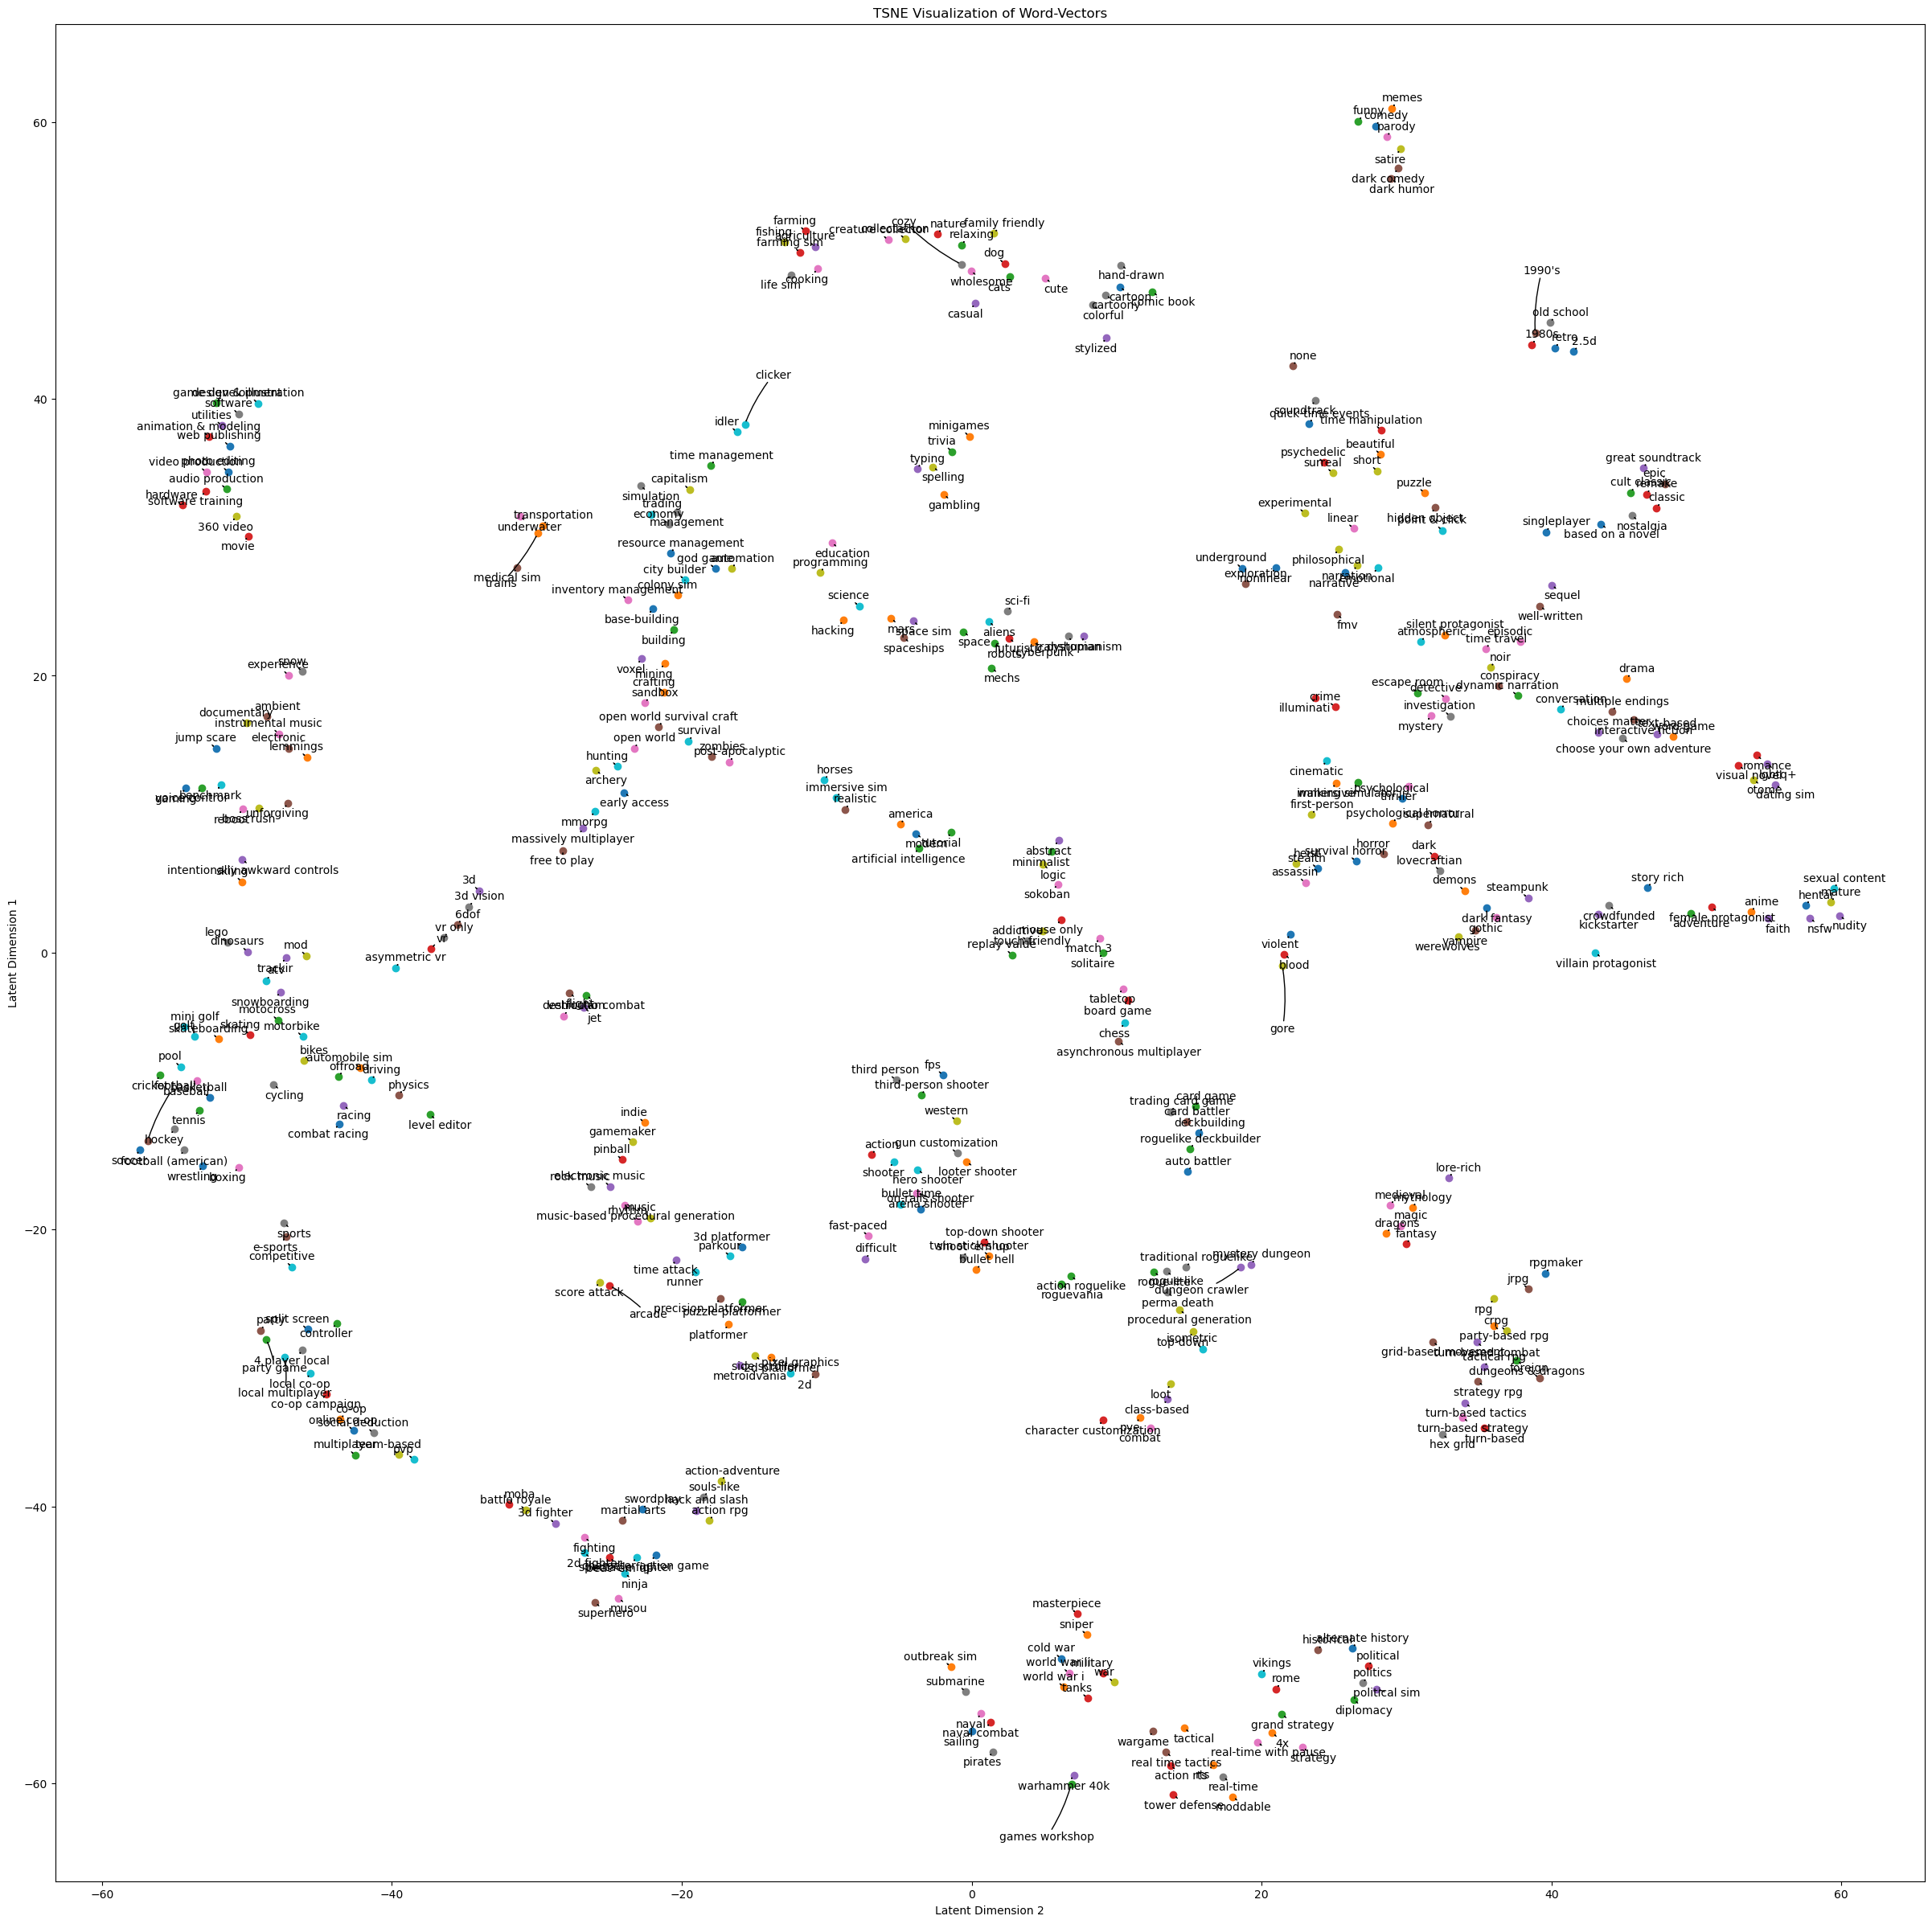

In [36]:
""" Code for graphing from:
    https://github.com/arsena-k/Word2Vec-bias-extraction/blob/master/Part_A_W2V_training_performance_exploring.ipynb
"""
def tsne_plot(words, vectors, iterations, seed, title):
    "Creates and TSNE model and plots it"
    # you may need to tune these, epsecially the perplexity. 
    tsne_model = TSNE(
        perplexity=7,
        n_components=2,
        init="pca",
        max_iter=iterations,
        random_state=seed,
        n_jobs=-1,
    )
    new_values = tsne_model.fit_transform(np.asarray(vectors))
    # pca = PCA(2, svd_solver='full', random_state=42)
    # new_values = pca.fit_transform(np.asarray(vectors))

    x,y, texts = [],[],[]
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(30, 30))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        texts.append( plt.text(
                s=words[i],
                #  xy=(x[i], y[i]),
                x=x[i], y=y[i],
                #  xytext=(x[i] + 0.1, y[i] - 0.2),
                #   xytext=(5, 2),
                #  textcoords='offset points',
                ha="center", va="center",))
    adjust_text(
        texts,
        expand=(6,5),
        explode_radius=(15),
        avoid_self=False,
        max_move=(13,13),
        force_text=(4,5),
        force_explode=(5,5),
        # force_static=(10,15),
        # pull_threshold=20,
        # force_pull=(0.1,0.1),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.08"),
    )
    plt.ylabel("Latent Dimension 1")
    plt.xlabel("Latent Dimension 2")
    plt.title(title)
    plt.show()


my_word_list, my_word_vectors, label = [], [], []

for i in w2vmodel.wv.index_to_key:
    try:
        if my_word_list not in my_word_list:
            my_word_vectors.append(w2vmodel.wv[i])
            my_word_list.append(i)
    except (
        KeyError
    ):  # if one of the words_to_explore is not in the model vocab, just skip it
        continue

tsne_plot(my_word_list, my_word_vectors, iterations=2000, seed=23, title="TSNE Visualization of Word-Vectors")

#### Averging word2vec vectors
The tag vectors corresponding to each game from the word2vec model are averaged to prepare a 100 dimensional embedding.


In [37]:
w2vmodel.wv.most_similar('action', topn=10)
w2vmodel.wv.similar_by_word('action', topn=10) # same result

[('shooter', 0.62510085105896),
 ('arena shooter', 0.5709104537963867),
 ('looter shooter', 0.5543228387832642),
 ('hero shooter', 0.5483404397964478),
 ('bullet time', 0.5396405458450317),
 ('blood', 0.5355928540229797),
 ('third-person shooter', 0.5251838564872742),
 ('on-rails shooter', 0.5236122608184814),
 ('twin stick shooter', 0.5059795379638672),
 ('parkour', 0.49379897117614746)]

In [38]:
words = w2vmodel.wv.index_to_key
words[0:10]
w2vmodel.wv.most_similar('none') # this needs fixin

[('soundtrack', 0.13714228570461273),
 ('comic book', 0.13697877526283264),
 ('drama', 0.1273394525051117),
 ('text-based', 0.1238269954919815),
 ('1980s', 0.11749564856290817),
 ('2.5d', 0.11477971076965332),
 ('combat', 0.11459926515817642),
 ('emotional', 0.11413487792015076),
 ('conversation', 0.11065410822629929),
 ('martial arts', 0.10723374038934708)]

In [39]:
"""
    pre-normalizing will discard sentence length information
    this should ignore differences in numbe of tags specified for each game
    Pre-normalize doesnt matter if init_sims(replace=True) since it will
    precompute normalized vectors.
    Not clear what the point of post_normalize is. May be/not good for training
    the regression model down the line.
"""

tags_vectors = [
    w2vmodel.wv.get_mean_vector(game, pre_normalize=False, post_normalize=False)
    for game in tag_processor.sentences
]

In [40]:
df['Tags'][6]

'Tower Defense,Rogue-lite,RTS,Replay Value,Perma Death,2D,Isometric,Difficult,Rogue-like,Dynamic Narration,Stylized,Real Time Tactics,Strategy,Minimalist,Abstract,Tactical,Atmospheric,Singleplayer,Sci-fi,Mystery'

In [41]:
w2vdf = pd.DataFrame(tags_vectors)
assert w2vdf.shape[1] == tags_w2v_model.num_features
w2vdf.columns = [f'w2v_embed_{i}' for i in range(tags_w2v_model.num_features)]
w2vdf.head()

,w2v_embed_0,w2v_embed_1,w2v_embed_2,w2v_embed_3,w2v_embed_4,w2v_embed_5,w2v_embed_6,w2v_embed_7,w2v_embed_8,w2v_embed_9,w2v_embed_10,w2v_embed_11,w2v_embed_12,w2v_embed_13,w2v_embed_14,w2v_embed_15,w2v_embed_16,w2v_embed_17,w2v_embed_18,w2v_embed_19,w2v_embed_20,w2v_embed_21,w2v_embed_22,w2v_embed_23,w2v_embed_24,w2v_embed_25,w2v_embed_26,w2v_embed_27,w2v_embed_28,w2v_embed_29,w2v_embed_30,w2v_embed_31,w2v_embed_32,w2v_embed_33,w2v_embed_34,w2v_embed_35,w2v_embed_36,w2v_embed_37,w2v_embed_38,w2v_embed_39,w2v_embed_40,w2v_embed_41,w2v_embed_42,w2v_embed_43,w2v_embed_44,w2v_embed_45,w2v_embed_46,w2v_embed_47,w2v_embed_48,w2v_embed_49,w2v_embed_50,w2v_embed_51,w2v_embed_52,w2v_embed_53,w2v_embed_54,w2v_embed_55,w2v_embed_56,w2v_embed_57,w2v_embed_58,w2v_embed_59,w2v_embed_60,w2v_embed_61,w2v_embed_62,w2v_embed_63,w2v_embed_64,w2v_embed_65,w2v_embed_66,w2v_embed_67,w2v_embed_68,w2v_embed_69,w2v_embed_70,w2v_embed_71,w2v_embed_72,w2v_embed_73,w2v_embed_74,w2v_embed_75,w2v_embed_76,w2v_embed_77,w2v_embed_78,w2v_embed_79,w2v_embed_80,w2v_embed_81,w2v_embed_82,w2v_embed_83,w2v_embed_84,w2v_embed_85,w2v_embed_86,w2v_embed_87,w2v_embed_88,w2v_embed_89,w2v_embed_90,w2v_embed_91,w2v_embed_92,w2v_embed_93,w2v_embed_94,w2v_embed_95,w2v_embed_96,w2v_embed_97,w2v_embed_98,w2v_embed_99,w2v_embed_100,w2v_embed_101,w2v_embed_102,w2v_embed_103,w2v_embed_104,w2v_embed_105,w2v_embed_106,w2v_embed_107,w2v_embed_108,w2v_embed_109,w2v_embed_110,w2v_embed_111,w2v_embed_112,w2v_embed_113,w2v_embed_114,w2v_embed_115,w2v_embed_116,w2v_embed_117,w2v_embed_118,w2v_embed_119,w2v_embed_120,w2v_embed_121,w2v_embed_122,w2v_embed_123,w2v_embed_124,w2v_embed_125,w2v_embed_126,w2v_embed_127,w2v_embed_128,w2v_embed_129,w2v_embed_130,w2v_embed_131,w2v_embed_132,w2v_embed_133,w2v_embed_134,w2v_embed_135,w2v_embed_136,w2v_embed_137,w2v_embed_138,w2v_embed_139,w2v_embed_140,w2v_embed_141,w2v_embed_142,w2v_embed_143,w2v_embed_144,w2v_embed_145,w2v_embed_146,w2v_embed_147,w2v_embed_148,w2v_embed_149
0,-0.041703,0.040414,-0.031432,-0.046559,0.010462,0.081126,-0.007823,0.040769,-0.013538,-0.047299,0.004126,-0.013796,0.039772,0.034654,0.037123,0.006098,0.041776,-0.045787,-0.017777,-0.006709,0.004749,-0.006747,0.018793,-0.013946,-0.018780,0.016041,-0.092523,-0.052604,0.065325,-0.033609,-0.040608,-0.034748,-0.020708,0.076379,-0.033162,0.007483,0.037064,-0.028224,-0.023574,-0.046092,0.015950,0.036000,-0.079728,0.042107,-0.039601,0.077033,-0.020958,0.077593,-0.038595,0.057400,0.005172,0.031070,-0.004203,-0.008218,0.030811,0.040598,-0.009307,-0.012227,0.032934,0.020001,-0.013816,0.009294,0.034319,-0.039265,-0.003049,-0.002057,0.003732,-0.074076,-0.033019,-0.018367,0.056739,0.007957,-0.040671,-0.073082,-0.024195,0.016226,-0.058070,-0.036974,0.013285,0.013360,0.037037,0.065705,-0.019954,0.064544,0.029802,-0.001092,-0.101699,-0.095798,0.006804,-0.012932,0.038883,0.062474,-0.006870,0.059366,-0.007720,0.042119,-0.049587,0.024853,0.002350,-0.009643,0.048711,0.066264,0.013740,-0.008384,-0.002969,-0.021767,-0.001804,0.006715,-0.079556,0.005132,-0.019598,-0.003561,-0.041909,-0.063060,-0.042630,-0.005905,-0.017377,0.014754,0.106682,0.071267,0.021277,-0.036322,0.006352,0.006481,-0.011462,-0.007704,0.118032,-0.060730,0.008322,0.028952,-0.061427,0.004992,0.011115,-0.021401,-0.009129,0.038041,-0.025963,0.008248,-0.062903,-0.070880,0.066320,-0.022148,0.020813,0.079444,0.010852,0.057249,-0.038809,-0.072223,0.006199,-0.034302
1,0.099624,-0.126640,-0.118061,-0.133925,0.125577,-0.036367,0.013609,-0.083613,-0.034582,0.000990,-0.034117,-0.100590,-0.084506,0.034594,-0.129555,0.015641,-0.027132,0.112962,-0.005428,0.084792,-0.096704,-0.103266,0.075682,0.012824,-0.069460,-0.036294,0.119687,-0.125231,-0.050168,0.013679,-0.002949,0.129818,-0.026450,-0.096820,-0.104781,-0.135098,-0.106758,-0.082322,-0.081150,-0.019175,-0.007385,-0.064343,0.029214,0.052752,0.123222,-0.063517,0.069982,0.098984,-0.051265,-0.101450,-0.045558,-0.094045,0.088633,0.128098,0.112888,-0.116453,0.068880,0.069592,0.076808,-0.113594,0

#### Dropping Tags columns and merging embeds

In [42]:
""" Trick to prevent this from executing twice """
try:
    check_if_w2vdf_already_concat
except NameError:
    df.drop(columns=['Tags'])
    df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, w2vdf], axis=1)
    check_if_w2vdf_already_concat = 1

# del check_if_w2vdf_already_concat

Best Parameters: {'min_samples': 50, 'min_cluster_size': 5, 'metric': 'euclidean', 'cluster_selection_method': 'leaf'}
DBCV score: 0.11530550496000577

## Processing Reviews Using Sentiment Analysis

In [ ]:
df_reviews.notna().sum()

4269

There are 4269 reveiws which we can analyze for sentiment. Using the Twitter Roberta model we get three scores (negative, neutral, positive) which are computed into a compound score using a simple weighting of [-1, 0, 1], respectively, and a dot product of the scores. These scores are then gathered and averaged into a single score for each game.

Please unzip the sentiment model from the google drive folder into the models directory.

When unzipped, the models directory should contain the folder `twitter-roberta-base-sentiment-latest` with 5 files inside.

In [ ]:

def calculate_sentiment():
    roberta_path = 'models/twitter-roberta-base-sentiment-latest'
    MODEL = roberta_path  # f"cardiffnlp/twitter-roberta-base-sentiment-latest"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = AutoConfig.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL);


    def preprocess(text: str):
        if (text.find("“") != -1):
            p = text.split("“")
            p = [x.split("”")[0].strip() for x in p]
            p = p[1:]
        else:
            # if it's just a single review or follows a different format
            # then just treat the whole string as a review
            p = [text]
        return p

    def calculate_compound_score(scores):
        sentiment_probabilities = np.asarray(scores)
        weights = np.array([-1, 0, 1], dtype=np.float32)
        return np.dot(sentiment_probabilities, weights)


    s = df_reviews[df_reviews.notna()]
    s = s.apply(preprocess)
    # Tweak batch to your system. 
    # Mem Usage: 10-50 is safe. ~25 may be fastest. Needs around 8gb ram.
    #=========
    batch_size = 25 
    #=========
    scores = []
    for i in range(0, s.size, batch_size): # compute in batches
        p = s[i:i + batch_size]
        pretokenized = [review for row in p.tolist() for review in row] # create a list of reviews 
        # pretokenized = "New WW2 Strategy Game Offers A Harrowing Look At Poland's Ill-Fated 1944 Uprising"
        # compute the tokens
        encoded_input = tokenizer(
            pretokenized, truncation=True, padding=True, max_length=512, return_tensors='pt')
        with torch.no_grad():
            output = model(**encoded_input)
        # gather scores in each batch
        scores.extend([calculate_compound_score(softmax(logits.numpy()))
                      for logits in output.logits])


    row_lengths = [len(reviews) for reviews in s.tolist()]
    row_lengths
    game_sentiments = np.split(scores, np.cumsum(row_lengths)) # review scores grouped by game

    if(game_sentiments[-1].shape == (0,)):
        game_sentiments = game_sentiments[:-1]

    game_sentiments = [np.mean(x) for x in game_sentiments] # average the score for each game

    df_review_scores = pd.Series(game_sentiments, index=s.index) # re-index

    # Copy df_reviews to avoid overwriting
    df_reviews_with_scores = df_reviews.copy()

    # Assign scores to the corresponding indices in the new series
    df_reviews_with_scores.loc[df_review_scores.index] = df_review_scores

    print(df_reviews_with_scores)
    return df_reviews_with_scores

try:
    df_reviews_with_scores = unpickle_model('df_reviews_with_scores-values')
except:
    print('No stored values found. Running fresh sentiment analysis.')
    df_reviews_with_scores = calculate_sentiment() 

In [ ]:
# pickle_model('df_reviews_with_scores', df_reviews_with_scores, {'no':'values'})
df_reviews_with_scores[df_reviews_with_scores.notna()]

10       0.302433
17       0.965187
44        0.71184
71       0.798158
80        0.37336
           ...   
83424    0.837488
83439    0.872737
83484    0.980012
83513    0.288159
83529    0.943047
Name: Reviews, Length: 4269, dtype: object

## Train/test data extraction + Regression model selection

The most important metrics when determinng a game's success include the number of estimated owners, peak ccu, number of pos/neg reveiws, and price.

In [ ]:
y = np.array(df[['Estimated owners', 'Peak CCU', 'Positive', 'Negative', 'Price']])
X = np.array(df.drop(columns=['AppID', 'Name', 'Estimated owners', 'Peak CCU', 'Positive', 'Negative', 'Price', 'Reviews', 'Notes', 'Developers', 'Publishers', 'Tags'], axis=1))

print(X.shape)
print(y.shape)

(20194, 180)
(20194, 5)


RandomForestRegressor is used to handle non-linear relationships between a game and the metrics we are predicting. MultiOutputRegressor provides easier setup for the model.

A grid search will also be done on the hyperparemeters for the random forest regressor.

In [ ]:

# 70% training data, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=52)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16155, 52) (16155, 5)
(4039, 52) (4039, 5)


In [ ]:
# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components for 80% variance
n_components = np.argmax(cumulative_variance >= 0.875) + 1  # Add 1 because index starts at 0

print(f"Number of components to preserve 87.5% variance: {n_components}")

Number of components to preserve 87.5% variance: 50


In [ ]:
feature_names = df.columns.to_list()
# Create a mapping between component weights and feature names
component_weights = pca.components_
feature_weights_mapping = {}
for i, component in enumerate(component_weights):
  component_feature_weights = zip(feature_names, component)
  sorted_feature_weight = sorted(
      component_feature_weights, key=lambda x: abs(x[1]), reverse=True)
  feature_weights_mapping[f"Component {i+1}"] = sorted_feature_weight
  
# Accessing feature names contributing to Principal Component
print("Feature names contributing to Principal Components")
data = [(feature, weight) for feature, weight in feature_weights_mapping.items()]
features_df = pd.DataFrame(data, columns=['Feature', 'Weight'])
features_df['Weight'] = features_df['Weight'].apply(lambda w: w[0:3])  # Keep only first 3 weights
features_df

Feature names contributing to Principal Components


,Feature,Weight
0,Component 1,"[(w2v_embed_40, 0.16946477048579817), (Web Pub..."
1,Component 2,"[(w2v_embed_56, 0.2069624456058417), (w2v_embe..."
2,Component 3,"[(w2v_embed_17, 0.21445985950573238), (w2v_emb..."
3,Component 4,"[(w2v_embed_58, 0.2243500079028247), (w2v_embe..."
4,Component 5,"[(w2v_embed_63, 0.2514964459158121), (Sexual C..."
5,Component 6,"[(w2v_embed_34, 0.21249784515374218), (w2v_emb..."
6,Component 7,"[(w2v_embed_3, 0.198795297332725), (Captions a..."
7,Component 8,"[(AppID, 0.19210674660837632), (w2v_embed_12, ..."
8,Component 9,"[(w2v_embed_53, 0.22897741296890778), (Educati..."
9,Component 10,"[(w2v_embed_0, 0.24585963294434748), (w2v_embe..."


Disclaimer, grid search takes hours to complete!

In [ ]:
perform_search = False
grid_search = None
if perform_search == True:
      # perform a grid search on hyperparameters for random forest
      # -1 to utilize all processors and speed up training time
      rf = RandomForestRegressor(random_state=42, n_jobs=-1)
      model = MultiOutputRegressor(rf, n_jobs=-1)

      param_grid = [
      {'estimator__n_estimators': [20, 50, 100, 150, 200, 250],
       'estimator__max_features': [1, 20, 'sqrt', 50, 70, 90, 110],
       'estimator__max_depth': [None, 10, 20, 30, 40, 50]}
      ]

      grid_search = GridSearchCV(model, param_grid, n_jobs=-1)
      grid_search.fit(X_train, y_train)

      pickle_model("rf_gridsearch_obj", grid_search, grid_search.best_params_, param_grid[0])
      print(grid_search.best_params_)

Best hyperparams were a max branch depth of 50, a random subset of 70 features for splitting branches, and 150 estimators/trees for random forest. These parameters are the most infuential to model capacity, generalization, and computation. Other parameters like min_samples_split were ommitted from grid search since the default is adequte to recognize patterns in the data.

In [ ]:

if perform_search == True:
    model = grid_search.best_estimator_
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    r2_score_values= r2_score(y_test, y_pred, multioutput='raw_values')

    # ['Estimated owners', 'Peak CCU', 'Positive', 'Negative', 'Price']
    print("Test set Mean Squared Error:", mse)
    print("Test set Root Mean Squared Error:", rmse)
    print("Test set R2 Score:", r2_score_values)

In [ ]:
# load saved model
""" You can download from link in README """
load_model = True
pca_model_filename = 'rf_pca'
pca_params = {'max_depth': 50, 'max_features': 70, 'n_estimators': 150}
for s in pca_params.values():
    pca_model_filename += f'-{s}'
try:
    if load_model != True:
        assert 'Training model'
    loaded_model = unpickle_model(pca_model_filename)
    model_pca = loaded_model
except:
    rf_pca = RandomForestRegressor(random_state=42, n_jobs=-1, verbose=1, **pca_params)
    model_pca = MultiOutputRegressor(rf_pca, n_jobs=-1)
    model_pca.fit(X_train, y_train)
    y_pred = model_pca.predict(X_test)
    pickle_model('rf_pca', model_pca, pca_params) 

if perform_search == False:
    y_pred = model_pca.predict(X_test)

    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    r2_score_values= r2_score(y_test, y_pred, multioutput='raw_values')

    # ['Estimated owners', 'Peak CCU', 'Positive', 'Negative', 'Price']
    print("Test set Mean Squared Error:", mse)
    print("Test set Root Mean Squared Error:", rmse)
    print("Test set R2 Score:", r2_score_values)

Test set Mean Squared Error: [6.85608839e-05 1.36304216e-05 5.07031382e-05 1.57729191e-04
 1.44286089e-03]
Test set Root Mean Squared Error: [0.00828015 0.00369194 0.00712061 0.01255903 0.03798501]
Test set R2 Score: [0.71123943 0.08947054 0.92144996 0.64463822 0.29049769]


In [ ]:
loaded_model.n_features_in_

52

In [ ]:
len(X_train[0])

52

In [ ]:
@dataclass
class DataMinMax:
    data:dict = field(default_factory=dict)


In [ ]:
predict_labels = ["Estimated owners", "Peak CCU", "Positive", "Negative", "Price"]
calc: DataMinMax = DataMinMax()
for i, label in enumerate(predict_labels):
    calc.data[label] = {
        "min": df_orig[label].min(),
        "max": df_orig[label].max(),
        "r2": r2_score_values[i],
        "rmse": rmse[i],
    }

In [ ]:
# Convert the data into a DataFrame
rows = []
for label in predict_labels:

    fmt_int = lambda x: f"{x:,.0f}"
    fmt_float = lambda x, precision=2: f"{x:,.{precision}f}"
    min_val = calc.data[label]["min"]
    max_val = calc.data[label]["max"]
    rmse_val = calc.data[label]["rmse"]
    r2_val = calc.data[label]["r2"]
    range_val = max_val - min_val
    range_percent = rmse_val * 100
    prediction = rmse_val*range_val
    rows.append({
        "Metric": label,
        "Prediction": fmt_float(prediction, 2),
        "Min": fmt_float(min_val,2),
        "Max": fmt_float(max_val),
        "RMSE": fmt_float(rmse_val, 4),
        "R^2": fmt_float(r2_val, 4),
        "Range (%)": fmt_float(range_percent,2),

    })

# Create DataFrame
df_result = pd.DataFrame(rows)

# Display the DataFrame
df_result

,Metric,Prediction,Min,Max,RMSE,R^2,Range (%)
0,Estimated owners,"620,928.45","10,000.00","75,000,000.00",0.0083,0.7112,0.83
1,Peak CCU,"3,219.88",1.00,"872,138.00",0.0037,0.0895,0.37
2,Positive,"6,871.27",0.00,"964,983.00",0.0071,0.9214,0.71
3,Negative,"1,739.80",0.00,"138,530.00",0.0126,0.6446,1.26
4,Price,10.24,0.35,269.99,0.0380,0.2905,3.80


Looking at the R2 Score, which indicates the proportion of variance in the dependent variable that is predictable from the independent variables, the model is able to capture underlying patterns decently for the estimated owners, positive number of reviews, and negative number of reviews. This suggests that relationships between the features and target variables are relatively strong, making them easier to predict.

This is logical. Game characteristics like developers, publishers, and categories will directly influence price and peak ccu  counts more so than the other target variables. Since these aren't taken into account during training to avoid too many feature encodings, the correlation between these characteristics makes them harder to predict. **This will help us assign a score to each prediction when defining a success rating.**



### Success Rating

The importance of each predicted parameter is determined by its R² score. Variables that account for a larger portion of their variance in predictions are given greater weights because they are more dependable.

The composite score will be calculated based on the R² weights, the accuracy of the predictions, and the sentiment score. High predictions for price and number of negative reveiws will be penalized since a game should maximize their peack ccu, esitmated owners, and number of positive reviews will minimizing cost.

In [ ]:
# compute weights of each predicted value based on r^2 value
r2_weights = r2_score_values / np.sum(r2_score_values) # weights add up to 1

# transform input data
X_scaled = scaler.transform(X)
X_pca = pca.transform(X_scaled)

# function that takes a random/chosen game, and computes its success rating
def success_rating(random=False, index=None):
    if random == True:
        index = np.random.randint(0, df.shape[0])

    game = X_pca[index]

    # collect predicted and actual metrics for the selected game
    predictions = model.predict(game.reshape(1,-1))  # ['Estimated owners', 'Peak CCU', 'Positive', 'Negative', 'Price']
    actual_metrics = y[index].reshape(1,-1)

    # Calculate RMSE for each predicted metric
    rmse = np.sqrt(mean_squared_error(actual_metrics, predictions, multioutput='raw_values')).reshape(1,-1)
    # normalize the rmse to prevent peak ccu and price from dominating the score (expecting large errors)
    rmse = min_max_normalize(rmse)


    sentiment_score = df_reviews_with_scores.iloc[index]

    # high 'price' and number of 'negative' reviews will be penalized
    contributions = r2_weights * rmse
    composite_score = np.sum(contributions[0, :3]) - np.sum(contributions[0, 3:-1])  + sentiment_score

    info = df_orig.iloc[index]

    return predictions, actual_metrics, composite_score, info

In [ ]:
_, _, score, game_info = success_rating(random=True)
#print("Predictions: ", game_predictions)
#print("Actual: ", game_metrics)
print("Score: ", score)
print(game_info.to_numpy())

To test how the score differers with different games, lets run 300 iterations of success_rating, and compare the scores to the different metrics that we predict.

In [ ]:
columns = [
    "Score", "AppID", "Name", "Release date", "Estimated owners", "Peak CCU",
    "Required age", "Price", "DLC count", "Reviews", "Windows",
    "Mac", "Linux", "Metacritic score", "User score", "Positive",
    "Negative", "Achievements", "Recommendations", "Notes",
    "Average playtime forever", "Average playtime two weeks",
    "Median playtime forever", "Median playtime two weeks",
    "Developers", "Publishers", "Categories", "Genres", "Tags"
]

# Create an empty DataFrame with these columns
table = pd.DataFrame(columns=columns)

# 300 trials to compare scores of different games
for i in range(300):
    _, _, score, game_info = success_rating(random=True)
    game = game_info.to_numpy()

    # Convert game_info to a dictionary with matching columns
    game_row = dict(zip(columns[1:], game_info))  # Exclude "Score" column
    game_row["Score"] = score

    # Append the dictionary as a new row to the DataFrame
    table = pd.concat([table, pd.DataFrame([game_row])], ignore_index=True)

In [ ]:
# drop any duplicates and print the table
table = table.drop_duplicates(subset=['AppID'])
table = table.sort_values(by='Score', ascending=False)
print(table.to_string())

In [ ]:
# illustrate the results by comparing the score to each predicted metric
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13,6))
fig, (ax5) = plt.subplots(1, 1, figsize=(6,6))

ax1.scatter(table["Estimated owners"], table["Score"], c='red')
ax1.set_xlabel('Estimated Owners')
ax1.set_ylabel('Score')
ax1.set_title('Estimated Owners vs Score')

ax2.scatter(table["Peak CCU"], table["Score"], c='blue')
ax2.set_xlabel('Peak CCU')
ax2.set_ylabel('Score')
ax2.set_title('Peak CCU vs Score')

ax3.scatter(table["Positive"], table["Score"], c='pink')
ax3.set_xlabel('Positive Reviews')
ax3.set_ylabel('Score')
ax3.set_title('Pos. Reviews vs Score')

ax4.scatter(table["Negative"], table["Score"], c='green')
ax4.set_xlabel('Negative Reviews')
ax4.set_ylabel('Score')
ax4.set_title('Neg. Reviews vs Score')

ax5.scatter(table["Price"], table["Score"], c='brown')
ax5.set_xlabel('Price')
ax5.set_ylabel('Score')
ax5.set_title('Price vs Score')


plt.show()